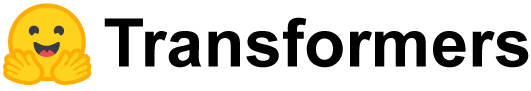

# <center>HuggingFace</center>

If you are interested in the field of NLP, chances are you've heard of HuggingFace Transformers. As their [GitHub page](https://github.com/huggingface/transformers) says, they provide **State-of-the-art Natural Language Processing for PyTorch and TensorFlow 2.0**

[Recently](https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681), they included support for zero-shot-classification. I am going to use this Zero-Shot Classification Pipeline for multi-class classification on the Arxiv Dataset.

# <center><b>Zero-Shot Classification</b></center>

Quite simply put, zero-shot classification refers to the class of machine learning problems where we want our models to predict output for classes which it did not encounter during training time. 

![Zero Shot Learning](https://amitness.com/images/zero-shot-vs-transfer.png)

Yup. In spite of no labelled training data, we can still get an output. How cool is that!

# <center>How does HuggingFace do Zero-Shot Classification?</center>

Quoting from their [introductory colab notebook](https://colab.research.google.com/drive/1jocViLorbwWIkTXKwxCOV9HLTaDDgCaw?usp=sharing) : 
> The underlying model is trained on the task of Natural Language Inference (NLI), which takes in two sequences and determines whether they contradict each other, entail each other, or neither.
> 
> This can be adapted to the task of zero-shot classification by treating the sequence which we want to classify as one NLI sequence (called the premise) and turning a candidate label into the other (the hypothesis). If the model predicts that the constructed premise _entails_ the hypothesis, then we can take that as a prediction that the label applies to the text.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.7 /opt/conda/lib/python3.7/site-packages/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-pj_bul5p/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=40.8.0' wheel
       cwd: None
  Complete output (42 lines):
  Traceback (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/pip/__main__.py", line 26, in <module>
      sys.exit(_main())
    File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
      command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
    File "/opt/conda/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 10

In [2]:
from transformers import pipeline
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# <center>Preparing the data</center>

We are only using training samples of papers which were published in the year 2020 for the purpose of this notebook

Source : [Notebook](https://www.kaggle.com/balraj98/arxiv-abstract-classification-using-roberta)

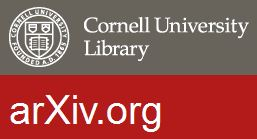

In [3]:
data_file = '../input/arxiv/arxiv-metadata-oai-snapshot.json'

""" Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

In [4]:
category_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

In [5]:
metadata = get_metadata()
ids = []
titles = []
abstracts = []
categories = []
for paper in metadata:
    metaDict = json.loads(paper)
    try:
        try:
            year = int(metaDict['journal-ref'][-4:])    ### Example Format: "Phys.Rev.D76:013009,2007"
        except:
            year = int(metaDict['journal-ref'][-5:-1])    ### Example Format: "Phys.Rev.D76:013009,(2007)"
        if(year == 2020):
            ids.append(metaDict['id'])
            titles.append(metaDict['title'])
            abstracts.append(metaDict['abstract'])
            categories.append(metaDict['categories'])
    except:
        pass

In [6]:
df = pd.DataFrame({'id' : ids,'title' : titles,'abstract' : abstracts, 'categories' : categories})
df.head()

,id,title,abstract,categories
0,0712.1975,Reentrant spin glass transition in LuFe2O4,We have carried out a comprehensive investig...,cond-mat.str-el cond-mat.mtrl-sci
1,0804.3104,"Teichm\""uller Structures and Dual Geometric Gi...",The Gibbs measure theory for smooth potentia...,math.DS math.CV
2,0810.5491,Nonequilibrium phase transition in a spreading...,We consider a nonequilibrium process on a ti...,cond-mat.stat-mech
3,0902.3288,Origin and evolution of cosmic accelerators - ...,One of the most tantalizing questions in ast...,astro-ph.CO astro-ph.HE
4,0908.2605,A use of geometric calculus to reduce Berezin ...,Berezin integration of functions of anticomm...,gr-qc


In [7]:
print(f'There are {df.shape[0]} rows in the dataset')

There are 24757 rows in the dataset


# <center>Preparing the pipeline in one-line of code!</center>

In [8]:
classifier = pipeline("zero-shot-classification",device = 0)

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# <center>Making Predictions</center>

For the purpose of this notebook, I am only making predictions on the first 100 data samples

In [9]:
candidate_labels = list(category_map.values()) #candidate labels are basically the classes that the classifier will predict
predictedCategories = []
trueCategories = []
for i in tqdm(range(100)):
    text = df.iloc[i,]['abstract']
    cat = df.iloc[i,]['categories']
    cat = cat.split()
    res = classifier(text, candidate_labels, multi_class=True)#setting multi-class as True
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = []
    for i, (k,v) in enumerate(sorted_dict.items()):
        if(i > 2): #storing only the best 3 predictions
            break
        else:
            categories.append(k)
    predictedCategories.append(categories)
    trueCats = [category_map[x] for x in cat]
    trueCategories.append(trueCats)

100%|██████████| 100/100 [07:30<00:00,  4.51s/it]


In [10]:
for y_true, y_pred in zip(trueCategories[:3], predictedCategories[:3]):
    print(f'True Categories {y_true}')
    print(f'Predicted Categories {y_pred}')
    print('#'*50)

True Categories ['Strongly Correlated Electrons', 'Materials Science']
Predicted Categories ['Complex Variables', 'High Energy Physics - Experiment', 'Applied Physics']
##################################################
True Categories ['Dynamical Systems', 'Complex Variables']
Predicted Categories ['Dynamical Systems', 'Applications', 'Sound']
##################################################
True Categories ['Statistical Mechanics']
Predicted Categories ['Applications', 'Complex Variables', 'Systems and Control']
##################################################


# <center>Manual One-Hot Encoding</center>

In [11]:
category_idx = {cat : i for i,cat in enumerate(category_map.values())} 

In [12]:
y_trueEncoded = []
y_predEncoded = []
for y_true, y_pred in zip(trueCategories, predictedCategories):
    encTrue = [0] * len(category_map)
    for cat in y_true:
        idx = category_idx[cat]
        encTrue[idx] = 1
    y_trueEncoded.append(encTrue)
    encPred = [0] * len(category_map)
    for cat in y_pred:
        idx = category_idx[cat]
        encPred[idx] = 1
    y_predEncoded.append(encPred)

# <center>Evaluation</center>

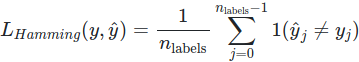

## Hamming Loss

### The Hamming loss is the fraction of labels that are incorrectly predicted.

In [13]:
from sklearn.metrics import hamming_loss
print(f'The hamming loss is {hamming_loss(y_trueEncoded,y_predEncoded):.4f}')

The hamming loss is 0.0288
